In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/news"

/content/drive/MyDrive/news


In [ ]:
# Para cargar datos y manipularlos
import pandas as pd
import numpy as np
import json
import os
import re
import string
import random

# Para el modelo
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Para EDA (augmentar texto)
import nltk
from nltk.corpus import wordnet

# Para dividir datos y matriz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Para visualizar
import matplotlib.pyplot as plt
import seaborn as sns

# wordnet
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Use gpu
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

try:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

except  SystemError as e:
    print(e)

GPU is NOT AVAILABLE
GPU device not found


In [ ]:

with open("/content/drive/MyDrive/news/News_Category_Dataset_v3.json", "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
# Obtener por cada linea, titulares y categorias
df = df[['headline', 'category']].dropna()


# Mapear categorias a indices
categories = df['category'].unique()
cat_to_index = {cat: idx for idx, cat in enumerate(categories)}
df['label'] = df['category'].map(cat_to_index)

# A minusculas, sin signos y espaciado normal, se aplica en los titulares
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['headline'] = df['headline'].apply(clean_text)

In [ ]:
# EDA - Easy Data Augmentation
# Wei, J., & Zou, K. (2019). EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks.
# Workshop paper presented at the International Conference on Learning Representations (ICLR) 2019. arXiv:1901.11196.
# usa wordnet (large lexical database of English) para buscar los sinonimos de n numero de palabras, y cambiarlas.
# Generas una lista de palabras (n largo) a reemplazar, y entonces buscas en wordnet el sinonimo
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def eda(text, alpha_sr=0.1):
    words = text.split()
    num_words = len(words)
    n_sr = max(1, int(alpha_sr * num_words))
    augs = synonym_replacement(words, n_sr)
    return ' '.join(augs)

# Data augmentation
augmented_texts = []
augmented_labels = []
for text, label in zip(df['headline'], df['label']):
    augmented_texts.append(text)
    augmented_labels.append(label)
    augmented_texts.append(eda(text))
    augmented_labels.append(label)

df_aug = pd.DataFrame({'headline': augmented_texts, 'label': augmented_labels})

In [ ]:
# División del dataset (80/20 train-test y luego 80/20 de train-val)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df_aug['headline'], df_aug['label'], test_size=0.2, stratify=df_aug['label'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Tokenización y padding
vocab_size = 10000
maxlen = 30
#Tokenizador de las 10 mil palabras mas frecuentes o le sale out of vocab
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
# Que todas las "palabras" salgan del mismo largo, porque sino es mas dificil procesarlas
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)


In [ ]:
# Early stopping (sin mejora mejor le cortas) y Checkpoint con el mejor modelo.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_path = "/content/drive/MyDrive/news/best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
# Cargar el modelo si ya existe
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)
    print("Modelo cargado desde archivo.")
else:
    # "Convolutional Neural Networks for Sentence Classification" Yoon Kim, 2014 Disponible en: https://arxiv.org/abs/1408.5882
    # Si veo estas 5 palabras (numeros) juntas, probablemente es una noticia de política
    # Las palabras con significados similares tendrán vectores cercanos entre sí
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
    history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=5, batch_size=32)


Epoch 1/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 281s 33ms/step - accuracy: 0.3976 - loss: 2.3739 - val_accuracy: 0.5684 - val_loss: 1.5913
Epoch 2/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 274s 27ms/step - accuracy: 0.5552 - loss: 1.6419 - val_accuracy: 0.5894 - val_loss: 1.4914
Epoch 3/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 236s 28ms/step - accuracy: 0.5872 - loss: 1.4853 - val_accuracy: 0.6060 - val_loss: 1.4332
Epoch 4/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 255s 27ms/step - accuracy: 0.6135 - loss: 1.3820 - val_accuracy: 0.6140 - val_loss: 1.3963
Epoch 5/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - accuracy: 0.6339 - loss: 1.3008 - val_accuracy: 0.6231 - val_loss: 1.3686
Epoch 6/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 269s 28ms/step - accuracy: 0.6493 - loss: 1.2317 - val_accuracy: 0.6315 - val_loss: 1.3526
Epoch 7/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 260s 28ms/step - accuracy: 0.6635 - loss: 1.1800 - val_accuracy: 0.6384 - val_loss: 1.3331
Epoch 8/50
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 263s 28ms/step - accuracy: 

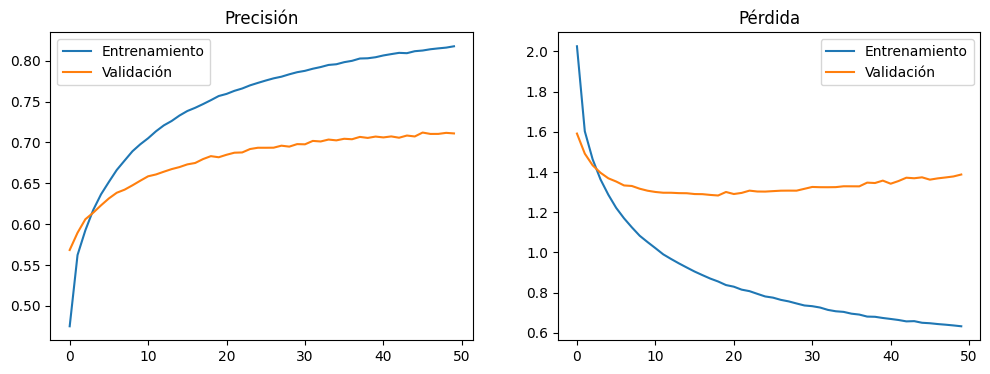

In [ ]:
# Accuracy vs loss
if 'history' in locals():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.legend()
    plt.show()


In [1]:
#Matriz de confuion de ssklearn
preds = model.predict(X_test_seq)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

print(classification_report(y_test, y_pred, target_names=categories))

# Resumen de TP,TN,FP,FN
def simple_confusion(matrix):
    correctas = sum(matrix[i][i] for i in range(len(matrix)))
    total = sum(sum(row) for row in matrix)
    incorrectas = total - correctas
    print("\nResumen de Clasificación:")
    print(f"Aciertos (Correctos): {correctas}")
    print(f"Errores (Incorrectos): {incorrectas}")
    print(f"Precisión global: {correctas / total:.2%}")

def resumen_tp_fp_fn_tn(matrix):
    num_classes = len(matrix)
    print("\nMatriz TP/FP/FN/TN por clase:")
    for i in range(num_classes):
        TP = matrix[i][i]
        FN = sum(matrix[i]) - TP
        FP = sum(matrix[j][i] for j in range(num_classes)) - TP
        TN = sum(sum(matrix[j]) for j in range(num_classes)) - (TP + FP + FN)
        print(f"Clase {i} -> TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

simple_confusion(cm)
resumen_tp_fp_fn_tn(cm)

NameError: name 'model' is not defined

In [2]:
# Prueba para benji
def predict_news(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad_seq = pad_sequences(seq, maxlen=maxlen)
    pred = model.predict(pad_seq)[0]
    category = categories[np.argmax(pred)]
    confidence = np.max(pred)
    print(f"Predicción: {category} ({confidence*100:.2f}%)")

# Uso:
predict_news("Korean beauty company causes acne")


NameError: name 'clean_text' is not defined